In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import os

In [2]:
PLAYER_ID_MAP = {
    'Fudge': 'eVlXNnq1sywmj-POOhNu7WBsy3pmRz7h39XjFZSfPWWLlkflaHQiS3slBOTuH491Vt4_YZS9RQ1TFw',
    'Blaber': '9aLFta7qA5e6UvvOBxl8uhuUKVkfF78l2FOwL2jfgd0QMZvKZGbvzBwt7PnCNbScEtgdhs0t4B_c-A',
    'EMENES': '45nCSt20TH_Fz98p-VKrNYs_T7hZwuG_QNy0Mor5hkUq5W9ZBn8SWAvZMhRlcNVRi7OwbjYp1fJ0dg',
    'Berserker': 'RrScs32xfyhzX7p9iF8GHCuUNTX8IwP50vGOGUFqdvy6TX-uo6ZNSRuOzvn9UeYxomUUYvMLCM8_1g',
    'Zven': 'cprO4fk7AsKjL1QdKjcGzaWEvozpEfLzJO4RuSLaZD45Fa20sjg6hXtQ9hgx9JWtF56ohF0cJsxCHg',
    'Licorice': 'wkY963ETw_5p8wJYOBKYBfF6sTDXenB5mCEafBKhVNDb0IslnG6CrBwJkl-2nc8tp_3GCd58YzWvJg',
    'River': 'ng1jT1r5rvglhAU0O_LPoP2C74zVRQ8eDtsdAJr_SQ9HLm4qA-jAOnxtdVg0kFQv1g_JZdb3s5iVnQ',
    'Gori': 'yRcKkojmP93HgmveaN8vmi2kJN7VhlC2hsp7OI_O7fVQLBNVLiePKy-cMbD9r8zVA25C7BaJjZQocQ',
    'Stixxay': 'KG1XYXD6dKX5jv29jBsX98dp9F7aGXYnykXdWR8xH9cbQgYLEYgXq3vGYdisEDuPzVDNmeUN2ZOkYA',
    'Huhi': 'cj7DQokoE2nJ7HJ-qyKaRtKX8klIQsES1UeuqrKSImDtGCCaQEgS80SVtDQ8hf4lfKnasvUp3iX7mQ'
}

In [3]:
CHAMPION_ID_MAP = None
with open('Data/champions_id_key.json', 'r') as file:
        CHAMPION_ID_MAP = json.load(file)

In [4]:
CHAMPION_ID_MAP = dict([(value, key) for key, value in CHAMPION_ID_MAP.items()])

In [5]:
def extract_relevant_data(raw_data: list, player_name: str):
    out_dict = defaultdict(list)
    for game in raw_data:

        out_dict['player'].append(player_name)

        # game version
        out_dict['game_version'].append(game['info']['gameVersion'])

        # game duration
        out_dict['game_duration'].append(game['info']['gameDuration'])

        # champion
        # find which participant they are
        i_player = game['metadata']['participants'].index(PLAYER_ID_MAP[player_name])
        out_dict['champion'].append(game['info']['participants'][i_player]['championName'])

        # kills/deaths/assists
        out_dict['kills'].append(game['info']['participants'][i_player]['kills'])
        out_dict['deaths'].append(game['info']['participants'][i_player]['deaths'])
        out_dict['assists'].append(game['info']['participants'][i_player]['assists'])

        # vision score
        out_dict['vision_score'].append(game['info']['participants'][i_player]['visionScore'])

        # gold
        out_dict['gold'].append(game['info']['participants'][i_player]['goldEarned'])

        # xp
        out_dict['xp'].append(game['info']['participants'][i_player]['champExperience'])

        # dmg/min
        out_dict['total_damage'].append(game['info']['participants'][i_player]['totalDamageDealtToChampions'])

        # role
        out_dict['role'].append(game['info']['participants'][i_player]['teamPosition'])

        # win
        out_dict['win'].append(game['info']['participants'][i_player]['win'])


    return pd.DataFrame(out_dict)

In [6]:
c9_json_files = [os.path.join('C9PlayerData/raw_json/', f) for f in os.listdir('C9PlayerData/raw_json')]
C9_dfs = {}
for f in c9_json_files:
    player_name = f.split('/')[-1].split('.')[0]
    with open(f, 'r+') as file:
        raw_data = json.load(file)
        C9_dfs[player_name] = extract_relevant_data(raw_data, player_name)

In [7]:
gg_json_files = [os.path.join('GGPlayerData/raw_json/', f) for f in os.listdir('GGPlayerData/raw_json')]
GG_dfs = {}
for f in gg_json_files:
    player_name = f.split('/')[-1].split('.')[0]
    with open(f, 'r+') as file:
        raw_data = json.load(file)
        GG_dfs[player_name] = extract_relevant_data(raw_data, player_name)

# Player Performance Model

In [8]:
from sklearn.linear_model import LogisticRegressionCV, LassoCV
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer

In [9]:
# filter out non-support roles
huhi_df = GG_dfs['Huhi'][GG_dfs['Huhi']['role'] == 'UTILITY']
zven_df = C9_dfs['Zven'][C9_dfs['Zven']['role'] == 'UTILITY']

In [10]:
def ScaleByGameDuration(df: pd.Series):
    return df.divide(df['game_duration']//60, axis=0)

In [11]:
def EncodeChampionId(col: pd.Series):
    return col.map(lambda x: int(CHAMPION_ID_MAP[x]))

In [12]:
colTransformer = ColumnTransformer([
    ('scaler', FunctionTransformer(ScaleByGameDuration, validate=False), ['game_duration', 'kills', 'deaths', 'assists', 'vision_score', 'gold', 'xp', 'total_damage']), 
    # ('encoder', FunctionTransformer(EncodeChampionId, validate=False), ['champion'])
])

In [13]:
combined = pd.concat([huhi_df, zven_df], axis=0)
y = combined['win']
X = combined.drop(axis=1, columns=['win'], inplace=False)
X = colTransformer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90)
y_train.mean(), y_test.mean()

(0.6217948717948718, 0.5384615384615384)

In [14]:
log_m = LogisticRegressionCV(random_state=101, max_iter=1000)
log_m.fit(X_train, y_train)
log_m.score(X_test, y_test)

0.8205128205128205

In [15]:
log_m.coef_

array([[-4.30066076e-01, -2.99628420e+00, -1.09640006e+01,
         5.10337634e+00,  8.42250910e-01,  5.66040047e-02,
         1.99743147e-03, -1.02838036e-02]])

In [16]:
def convert_format(X):
    y = X['win']
    X = X.drop(axis=1, columns=['win'], inplace=False)
    X = colTransformer.fit_transform(X)
    return X

champ_proabilities = combined[combined['player'] == 'Zven'].groupby('champion').apply(lambda x: log_m.predict_proba(convert_format(x))[:, 1])
champ_proabilities.apply(np.mean)

champion
Alistar         0.561486
Bard            0.936646
Blitzcrank      0.704200
Braum           0.968743
Heimerdinger    0.176465
Karma           0.497676
Leona           0.069637
Lux             0.768320
Nautilus        0.441678
Rakan           0.678938
Rell            0.588360
Senna           0.929900
Taric           0.783815
Zyra            0.000018
dtype: float64

In [17]:
np.set_printoptions(suppress=True)

In [18]:
log_m.coef_

array([[ -0.43006608,  -2.9962842 , -10.96400063,   5.10337634,
          0.84225091,   0.056604  ,   0.00199743,  -0.0102838 ]])

In [19]:
d_tree = DecisionTreeClassifier(max_depth=3, random_state=101)
d_tree.fit(X_train, y_train)
print(d_tree.score(X_test, y_test))

tree_text = export_text(d_tree, feature_names=['game_duration', 'kills', 'deaths', 'assists', 'vision_score', 'gold', 'xp', 'total_damage'])
print(tree_text)

0.8461538461538461
|--- assists <= 0.53
|   |--- deaths <= 0.15
|   |   |--- assists <= 0.25
|   |   |   |--- class: False
|   |   |--- assists >  0.25
|   |   |   |--- class: True
|   |--- deaths >  0.15
|   |   |--- xp <= 371.73
|   |   |   |--- class: False
|   |   |--- xp >  371.73
|   |   |   |--- class: True
|--- assists >  0.53
|   |--- deaths <= 0.30
|   |   |--- gold <= 296.50
|   |   |   |--- class: True
|   |   |--- gold >  296.50
|   |   |   |--- class: True
|   |--- deaths >  0.30
|   |   |--- class: False



In [20]:
# Main Data Imports
game_summary = pd.read_parquet('Data/game_summary.parquet')
player_game_stats = pd.read_parquet('Data/player_game_stats.parquet')

In [21]:
game_summary.columns

Index(['game_urn', 'match_perid', 'region', 'game_start_date_time',
       'series_type', 'series_max', 'series_curr', 'team_1_urn', 'team_1_name',
       'team_1_side', 'team_2_urn', 'team_2_name', 'team_2_side',
       'winning_team_urn', 'winning_team', 'winning_side',
       'game_duration_mins', 'bb1', 'rb1', 'bb2', 'rb2', 'bb3', 'rb3', 'bp1',
       'rp1', 'rp2', 'bp2', 'bp3', 'rp3', 'rb4', 'bb4', 'rb5', 'bb5', 'rp4',
       'bp4', 'bp5', 'rp5', 'team_1_perid', 'team_2_perid',
       'winning_team_perid', 'upsert_at', 'team_1_top', 'team_1_top_pick_num',
       'team_1_jng', 'team_1_jng_pick_num', 'team_1_mid',
       'team_1_mid_pick_num', 'team_1_bot', 'team_1_bot_pick_num',
       'team_1_sup', 'team_1_sup_pick_num', 'team_2_top',
       'team_2_top_pick_num', 'team_2_jng', 'team_2_jng_pick_num',
       'team_2_mid', 'team_2_mid_pick_num', 'team_2_bot',
       'team_2_bot_pick_num', 'team_2_sup', 'team_2_sup_pick_num',
       'game_version'],
      dtype='object')

In [22]:
player_game_stats[player_game_stats['role'] == 'sup']

,game_urn,player_urn,team_urn,region,game_start_datetime,best_of,curr_game,player,team,champion,...,vision_score,jungle_prox,duo_prox,team_perid,player_perid,opp_player_perid,opp_team_urn_perid,upsert_at,gold_at_20m,gold_diff_at_20m
0,live:lol:riot:map:esportstmnt01-3373466,live:lol:riot:player:37643ce5-d0ef-31f1-a000-a...,live:lol:riot:team:99294153824386385,LCS,2023-06-14 21:13:15.338000+00:00,1,1,huhi,GG,Nami,...,87.457497,0.322147,0.430611,esports:team:44f6a80f-b0b7-432e-b6fe-1127ed555938,esports:player:cd2bc07a-142e-4f89-bb89-b48eff2...,esports:player:f055bb59-5b23-4ba1-babe-f362412...,esports:team:c2be4c5e-e1e3-4c05-8098-914da28289ab,2023-06-14 22:04:29.271665+00:00,None,None
5,live:lol:riot:map:esportstmnt01-3373466,live:lol:riot:player:c5b97127-7d85-3d54-ab35-e...,live:lol:riot:team:98767991877340524,LCS,2023-06-14 21:13:15.338000+00:00,1,1,Zven,C9,Milio,...,76.175224,0.098639,0.693022,esports:team:c2be4c5e-e1e3-4c05-8098-914da28289ab,esports:player:f055bb59-5b23-4ba1-babe-f362412...,esports:player:cd2bc07a-142e-4f89-bb89-b48eff2...,esports:team:44f6a80f-b0b7-432e-b6fe-1127ed555938,2023-06-14 22:04:29.271665+00:00,None,None
15,live:lol:riot:map:esportstmnt01-3375039,live:lol:riot:player:53eebeb2-1202-37c6-a479-9...,live:lol:riot:team:98926509883054987,LCS,2023-06-15 21:07:21.465000+00:00,1,1,Diamond,DIG,Thresh,...,69.159447,0.219468,0.504249,esports:team:129cfc07-4f37-4f10-af3a-6f0d78c8a208,esports:player:1e88afe8-9842-4b58-85cb-5464082...,esports:player:f055bb59-5b23-4ba1-babe-f362412...,esports:team:c2be4c5e-e1e3-4c05-8098-914da28289ab,2023-06-15 22:04:41.129026+00:00,None,None
19,live:lol:riot:map:esportstmnt01-3375039,live:lol:riot:player:c5b97127-7d85-3d54-ab35-e...,live:lol:riot:team:98767991877340524,LCS,2023-06-15 21:07:21.465000+00:00,1,1,Zven,C9,Lulu,...,76.979721,0.173675,0.522244,esports:team:c2be4c5e-e1e3-4c05-8098-914da28289ab,esports:player:f055bb59-5b23-4ba1-babe-f362412...,esports:player:1e88afe8-9842-4b58-85cb-5464082...,esports:team:129cfc07-4f37-4f10-af3a-6f0d78c8a208,2023-06-15 22:04:41.129026+00:00,None,None
24,live:lol:riot:map:esportstmnt01-3376646,live:lol:riot:player:c5b97127-7d85-3d54-ab35-e...,live:lol:riot:team:98767991877340524,LCS,2023-06-17 00:49:39.089000+00:00,1,1,Zven,C9,Milio,...,77.854523,0.118263,0.445760,esports:team:c2be4c5e-e1e3-4c05-8098-914da28289ab,esports:player:f055bb59-5b23-4ba1-babe-f362412...,esports:player:c9178cdf-fb86-448b-9d5d-b6d2874...,esports:team:c7fb2ef8-27bf-4363-b1a5-b68f11ec272e,2023-06-17 02:04:40.670150+00:00,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,live:lol:riot:map:esportstmnt03-3194810,live:lol:riot:player:37643ce5-d0ef-31f1-a000-a...,live:lol:riot:team:99294153824386385,LCS,2023-07-21 22:52:33.053000+00:00,1,1,huhi,GG,Leona,...,164.373123,0.304828,0.373668,esports:team:44f6a80f-b0b7-432e-b6fe-1127ed555938,esports:player:cd2bc07a-142e-4f89-bb89-b48eff2...,esports:player:b7cc9b65-5821-4fbd-b9ef-d8a4c59...,esports:team:19a82dc3-96de-474c-8ed1-ced74b0f08cd,2023-07-22 00:04:50.806356+00:00,None,None
554,live:lol:riot:map:esportstmnt03-3194842,live:lol:riot:player:37643ce5-d0ef-31f1-a000-a...,live:lol:riot:team:99294153824386385,LCS,2023-07-22 02:23:40.206000+00:00,1,1,huhi,GG,Nautilus,...,83.699425,0.212528,0.420796,esports:team:44f6a80f-b0b7-432e-b6fe-1127ed555938,esports:player:cd2bc07a-142e-4f89-bb89-b48eff2...,esports:player:f055bb59-5b23-4ba1-babe-f362412...,esports:team:c2be4c5e-e1e3-4c05-8098-914da28289ab,2023-07-22 03:05:16.127556+00:00,None,None
559,live:lol:riot:map:esportstmnt03-3194842,live:lol:riot:player:c5b97127-7d85-3d54-ab35-e...,live:lol:riot:team:98767991877340524,LCS,2023-07-22 02:23:40.206000+00:00,1,1,Zven,C9,Milio,...,74.936974,0.170129,0.517269,esports:team:c2be4c5e-e1e3-4c05-8098-914da28289ab,esports:player:f055bb59-5b23-4ba1-babe-f362412...,esports:player:cd2bc07a-142e-4f89-bb89-b48eff2...,esports:team:44f6a80f-b0b7-432e-b6fe-1127ed555938,2023-07-22 03:05:16.127556+00:00,N

In [23]:
player_game_stats.shape

(570, 56)

In [24]:
player_game_stats.loc[0, player_game_stats.columns.str.contains('opp')]

opp_player_urn        live:lol:riot:player:c5b97127-7d85-3d54-ab35-e...
opp_player                                                         Zven
opp_team_urn                       live:lol:riot:team:98767991877340524
opp_team                                                             C9
opp_champion                                                      Milio
opp_player_perid      esports:player:f055bb59-5b23-4ba1-babe-f362412...
opp_team_urn_perid    esports:team:c2be4c5e-e1e3-4c05-8098-914da28289ab
Name: 0, dtype: object

In [83]:
C9_games = player_game_stats[(player_game_stats['opp_team'] == 'C9') | (player_game_stats['team'] == 'C9')]

In [48]:
# sns.histplot(C9_games, x='jungle_prox', hue='role', bins=20)
# plt.show()

In [49]:
C9_games.columns

Index(['game_urn', 'player_urn', 'team_urn', 'region', 'game_start_datetime',
       'best_of', 'curr_game', 'player', 'team', 'champion', 'side', 'role',
       'opp_player_urn', 'opp_player', 'opp_team_urn', 'opp_team',
       'opp_champion', 'result', 'kills', 'deaths', 'assists', 'double_kills',
       'triple_kills', 'quad_kills', 'penta_kills', 'first_blood',
       'avg_mins_between_kills', 'avg_mins_between_deaths', 'solo_kills',
       'iso_deaths', 'minion_kills', 'neutral_minion_kills',
       'neutral_minion_kills_team_jungle', 'neutral_minion_kills_enemy_jungle',
       'perc_in_mid_lane', 'num_recalls', 'total_damage_teamfights',
       'avg_damage_per_teamfight', 'dmg_to_champs_per_min',
       'dmg_shielded_on_team_per_min', 'dmg_healed_on_team_per_min',
       'total_gold', 'gold_at_15m', 'gold_diff_at_15m', 'wards_placed',
       'wards_killed', 'vision_score', 'jungle_prox', 'duo_prox', 'team_perid',
       'player_perid', 'opp_player_perid', 'opp_team_urn_perid', 'u

In [50]:
game_summary_reduced = game_summary[['game_urn', 'winning_team', 'team_1_name', 'team_2_name']]


In [144]:
from itertools import chain, combinations

# Function to get all combinations of a set (with at least 2 elements)
def powerset(comp):
    s = list(comp)
    return chain.from_iterable(combinations(s, r) for r in range(2, len(s)+1))

# Merge with game_summary to determine if C9 won or lost
game_summary_reduced = game_summary[['game_urn', 'winning_team', 'team_1_name', 'team_2_name']]
merged_df = C9_games.merge(game_summary_reduced, on='game_urn', how='left')
merged_df['c9_win'] = merged_df['winning_team'] == 'C9'

# Group by game_urn and get champion compositions
interm1 = merged_df.groupby(['game_urn', 'side', 'team', 'c9_win'])[['champion']].apply(lambda x: set(x['champion'].to_numpy())).reset_index()

# Filter only for the C9 team
interm2 = interm1[interm1['team'] == 'C9']

champ_combos = []
wins = []
for i, row in interm2[[0, 'c9_win']].iterrows():
    next_combination = list(powerset(row[0]))
    wins.extend([row['c9_win']]*len(next_combination))
    champ_combos.extend(next_combination)

In [152]:
comp_wins = pd.DataFrame().from_records({'comps': champ_combos, 'win': wins})

In [166]:
valid_comps = (comp_wins['comps'].value_counts() > 2)[comp_wins['comps'].value_counts() > 2].index

In [168]:
comps_g2 = comp_wins.loc[comp_wins['comps'].isin(valid_comps), :]

<Axes: xlabel='count', ylabel='comps'>

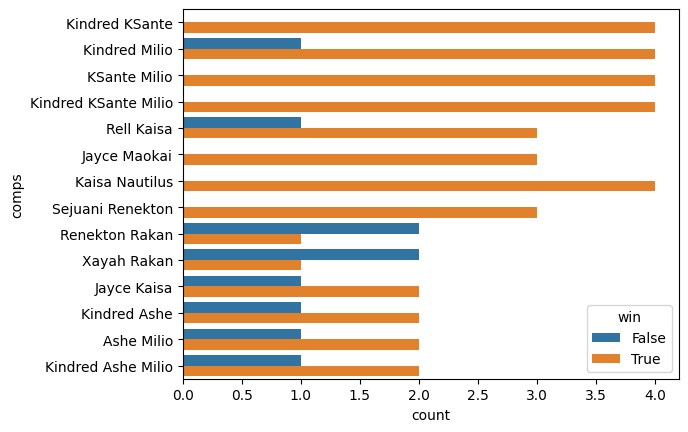

In [171]:
sns.countplot(y=comps_g2['comps'].str.join(' '), hue=comps_g2['win'])

Winrate over the LCS split on individual champs -> pick priority/ban priority -> who they've been playing in soloqueue + winrate -> who to ban/lookout for against them.

In [121]:
game_summary[]

,bp1,bp2,bp3,bp4,bp5
0,Milio,Kindred,Zeri,Gragas,KSante
1,KSante,Maokai,Jinx,Ahri,Thresh
2,KSante,Lucian,Nami,Nautilus,Rumble
3,Annie,Xayah,Rakan,Viego,Gragas
4,Milio,Aphelios,Kindred,Gragas,KSante
5,Azir,Maokai,Ashe,Poppy,Milio
6,Neeko,Nocturne,Kennen,Kaisa,Nautilus
7,Annie,MonkeyKing,Aphelios,Ornn,Rakan
8,Neeko,Xayah,Rakan,Sion,MonkeyKing
9,Vi,Azir,Jax,Aphelios,Leona


In [ ]:
C9_games = player_game_stats[(player_game_stats['opp_team'] == 'C9') | (player_game_stats['team'] == 'C9')]
game_summary_reduced = game_summary[['game_urn', 'winning_team', 'team_1_name', 'team_2_name']]
merged_df = C9_games.merge(game_summary_reduced, on='game_urn', how='left')
merged_df['c9_win'] = merged_df['winning_team'] == 'C9'

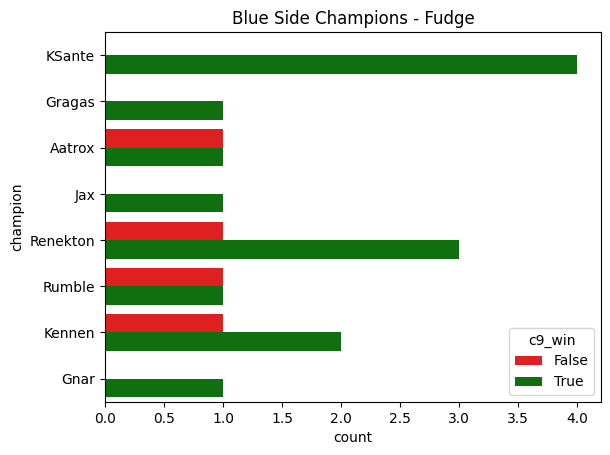

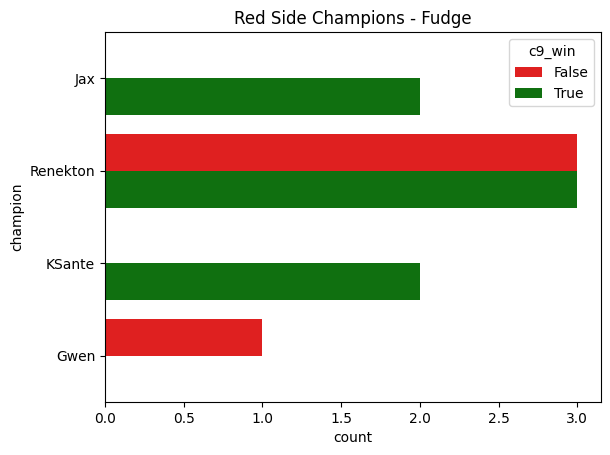

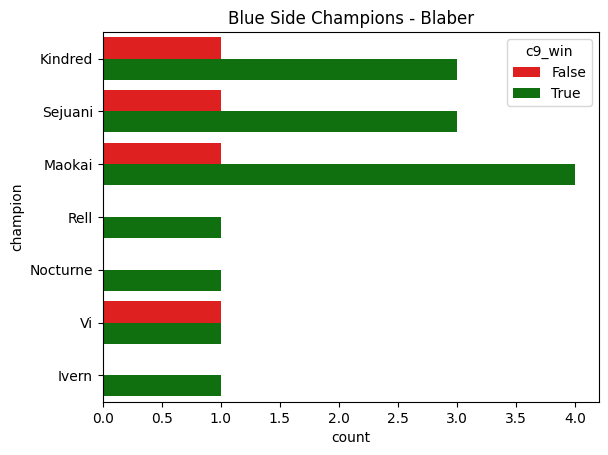

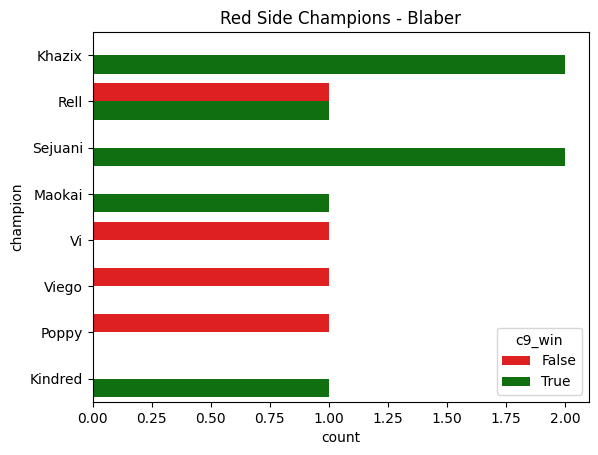

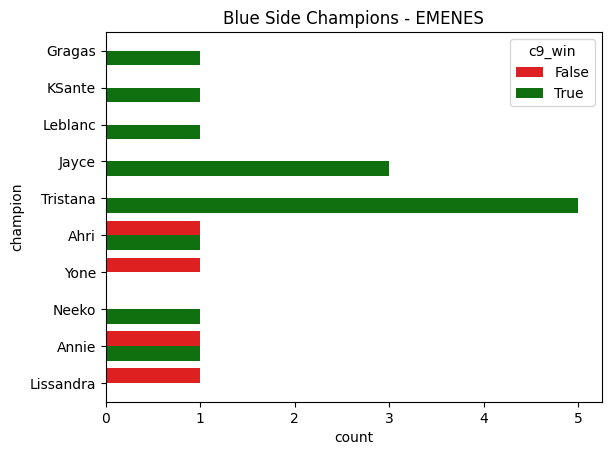

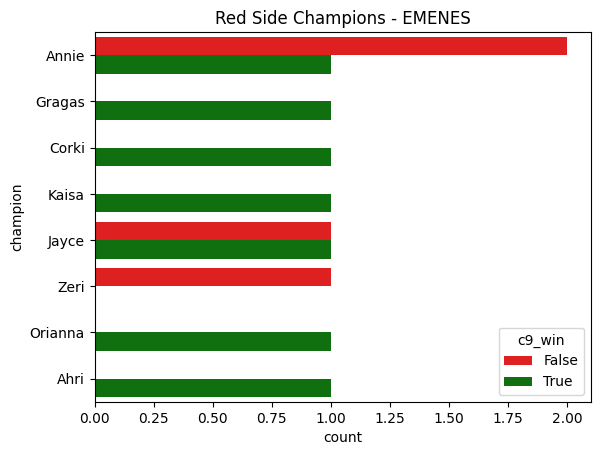

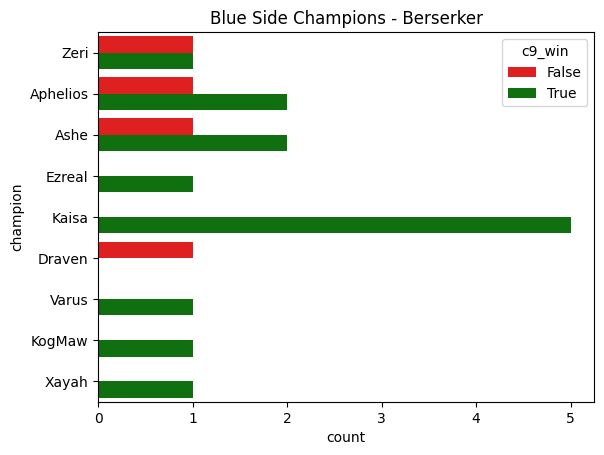

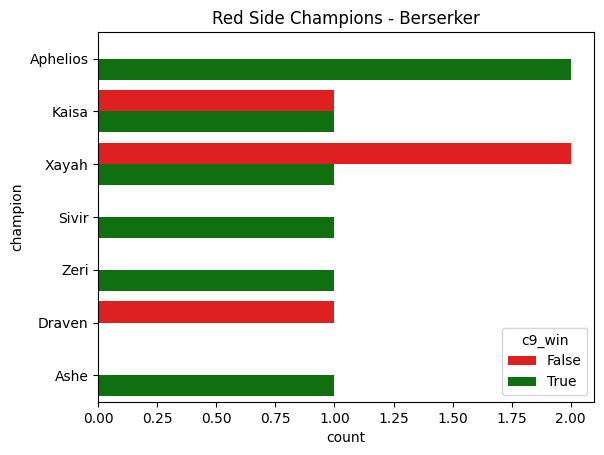

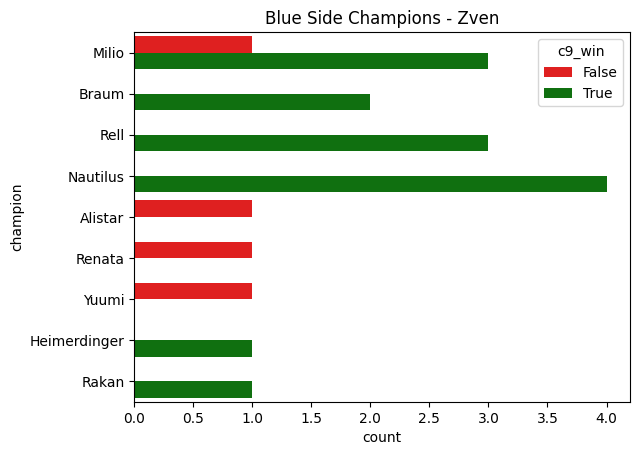

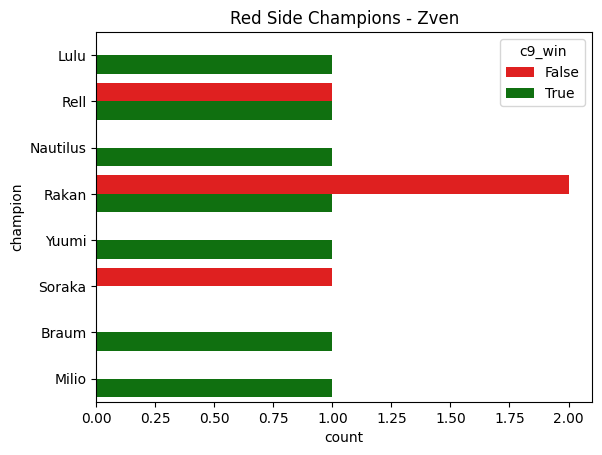

In [120]:
# iterate for each player
for player in ['Fudge', 'Blaber', 'EMENES', 'Berserker', 'Zven']:
    # get the player's games
    player_games = C9_games[(C9_games['player'] == player) | (C9_games['opp_player'] == player)]

    # create histogram of counts of each champion
    player_games = merged_df[(merged_df['player'] == player)]
    pg_sm = player_games[['champion', 'side', 'c9_win']]

    sns.countplot(data=pg_sm[pg_sm['side'] == 'blue'], y='champion', hue='c9_win', palette={True: "g", False: "r"})
    plt.title(f'Blue Side Champions - {player}')
    plt.show()
    sns.countplot(data=pg_sm[pg_sm['side'] == 'red'], y='champion', hue='c9_win', palette={True: "g", False: "r"})
    plt.title(f'Red Side Champions - {player}')
    plt.show()

In [105]:
C9_games = player_game_stats[(player_game_stats['opp_team'] == 'C9') | (player_game_stats['team'] == 'C9')]
game_summary_reduced = game_summary[['game_urn', 'winning_team', 'team_1_name', 'team_2_name']]
merged_df = C9_games.merge(game_summary_reduced, on='game_urn', how='left')
merged_df['c9_win'] = merged_df['winning_team'] == 'C9'

In [117]:
player = 'Blaber'
player_games = merged_df[(merged_df['player'] == player)]
pg_sm = player_games[['champion', 'side', 'c9_win']]

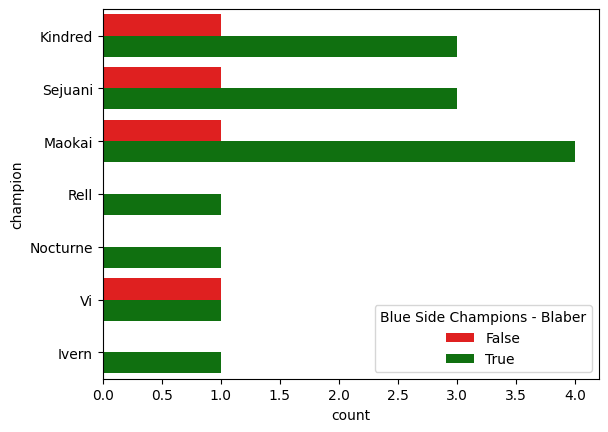

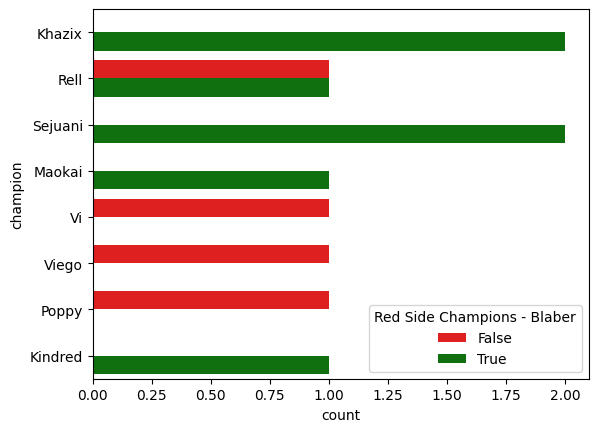

In [118]:
sns.countplot(data=pg_sm[pg_sm['side'] == 'blue'], y='champion', hue='c9_win', palette={True: "g", False: "r"})
plt.legend(title=f'Blue Side Champions - {player}')
plt.show()
sns.countplot(data=pg_sm[pg_sm['side'] == 'red'], y='champion', hue='c9_win', palette={True: "g", False: "r"})
plt.legend(title=f'Red Side Champions - {player}')
plt.show()

In [80]:
player_games['side'].value_counts()

side
blue    18
red     11
Name: count, dtype: int64